In [1]:
!nvidia-smi

Thu Jan  9 09:27:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [0]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [4]:
# %%capture
%%bash
apt-get install cmake
apt-get install zlib1g-dev
pip install JSAnimation
pip install gym-super-mario-bros

Reading package lists...
Building dependency tree...
Reading state information...
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
zlib1g-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
  Created wheel for JSAnimation: filename=JSAnimation-0.1-cp36-none-any.whl size=11425 sha256=c9dcfbf2d6a8043541cf311904811b4ae32d5be4576585546a77321b6b1fc2af
  Stored in directory: /root/.cache/pip/wheels/3c/c2/b2/b444dffc3eed9c78139288d301c4009a42c0dd061d3b62cead
Succes

In [0]:
import numpy as np
# import cPickle as pickle
import matplotlib.pyplot as plt
from JSAnimation.IPython_display import display_animation
import gym
from collections import deque
from matplotlib import animation, rc
from IPython.display import HTML
from IPython.display import clear_output

%matplotlib inline

In [6]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
env = gym_super_mario_bros.make('SuperMarioBros-v2')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [0]:
# env = gym.make('CartPole-v1')
# env.reset()
# env.render(mode='rgb_array')
#obs = env.reset()

#np.shape(obs),obs[:,:,0].shape

In [0]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=25)
    return anim

In [10]:
#pool = nn.AvgPool2d(2, ceil_mode=True)
def preprocess_old(frame):
    #frame = frame[:,:,1]
    frame = frame.sum(axis=-1)/768
    frame = frame[20:180,100:]
    frame = frame[::2,::2]
    return frame
 
def preprocess(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    l = np.array([3,1,5])
    l =l/l.sum()

    #gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    gray = l[0]*r + l[1]*g + l[2]*b
    gray = gray[80:210,100:]
    gray = gray[::3,::3]
    #gray=torch.tensor(gray)
    #gray=pool(gray.unsqueeze(-1).permute(2,0,1))
    #gray = np.array(gray.permute(1,2,0).squeeze(-1))
    return gray

obs = env.reset()
print(type(obs),np.shape(obs))
obs = preprocess(obs)
print(type(obs),np.shape(obs))

<class 'numpy.ndarray'> (240, 256, 3)
<class 'numpy.ndarray'> (44, 52)


/usr/local/lib/python3.6/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


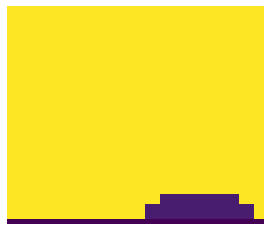

In [12]:
env.reset()
frames = []#np.zeros((2000, 240, 256, 3), dtype=np.uint8)
frames1 = []
for t in range(500):

    obs, reward, done, info = env.step(np.random.randint(2,4))
    frames1.append(np.array(obs,dtype=np.uint8))
    obs = preprocess(obs)
    frames.append(np.array(obs))#,dtype=np.uint8))
anim=display_frames_as_gif(np.array(frames))
HTML(anim.to_html5_video())
#print(type(obs))


In [13]:
type(np.random.rand(3,3))

numpy.ndarray

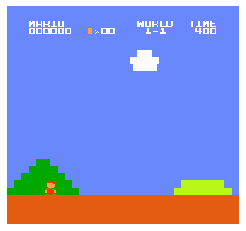

In [14]:
 anim1=display_frames_as_gif(np.array(frames1))
 HTML(anim1.to_html5_video())

## Models

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetworkDuellingCNN1(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(ActorCritic, self).__init__()
        self.conv1 = nn.Conv2d(num_inputs, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.lstm = nn.LSTMCell(32 * 6 * 6, 512)
        self.critic_linear = nn.Linear(512, 1)
        self.actor_linear = nn.Linear(512, num_actions)
        self._initialize_weights()

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                # nn.init.kaiming_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.LSTMCell):
                nn.init.constant_(module.bias_ih, 0)
                nn.init.constant_(module.bias_hh, 0)

    def forward(self, x, hx, cx):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.reshape(x.shape[0], -1)
        #hx, cx = self.lstm(x.view(x.size(0), -1), (hx, cx))
        return self.actor_linear(hx), self.critic_linear(hx), hx, cx


class QNetworkDuellingCNN(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, channels, action_size, seed=42):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetworkDuellingCNN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.conv1 = nn.Conv2d(channels, 4, 3, padding=1)
        self.conv2 = nn.Conv2d(4, 8, 3, padding=1)
        self.conv3 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv4 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv5 = nn.Conv2d(16, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(4)
        self.bn2 = nn.BatchNorm2d(8)
        self.bn3 = nn.BatchNorm2d(16)
        self.bn4 = nn.BatchNorm2d(16)
        self.bn5 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, ceil_mode=True)
        
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)

        flat_len = 672
        self.fcval = nn.Linear(flat_len, 20)
        self.fcval2 = nn.Linear(20, 1)
        self.fcadv = nn.Linear(flat_len, 20)
        self.fcadv2 = nn.Linear(20, action_size)

    def forward(self, x):
        """Build a network that maps state -> action values."""
        x = F.relu(self.bn1(self.conv1(x)))
        
        x = F.relu(self.bn2(self.conv2(x)))
        
        x = self.pool(
            F.relu(self.bn3(self.conv3(x))))
        
        x = self.pool(
            F.relu(self.bn4(self.conv4(x))))
        
        x = self.pool(
            F.relu(self.bn5(self.conv5(x))))

        
        x = x.reshape(x.shape[0], -1)
        
        advantage = F.relu(self.fcadv(x))
        advantage = self.fcadv2(advantage)
        advantage = advantage - torch.mean(advantage, dim=-1, keepdim=True)
        
        value = F.relu(self.fcval(x))
        value = self.fcval2(value)

        return value + advantage

## Memory buffer
Saves States, Actions, Rewards, Next States (SARS) and Dones.

If priority sampling is required, we sample according to the error of the model.

In [0]:
import torch
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, state_size, action_size, buffer_size, batch_size, priority=False):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer (chosen as multiple of num agents)
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.states = torch.zeros((buffer_size,)+state_size).to(device)
        self.next_states = torch.zeros((buffer_size,)+state_size).to(device)
        self.actions = torch.zeros(buffer_size,1, dtype=torch.long).to(device)
        self.rewards = torch.zeros(buffer_size, 1, dtype=torch.float).to(device)
        self.dones = torch.zeros(buffer_size, 1, dtype=torch.float).to(device)
        self.e = np.zeros((buffer_size, 1), dtype=np.float)
        
        self.priority = priority

        self.ptr = 0
        self.n = 0
        self.buffer_size = buffer_size
        self.batch_size = batch_size
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        self.states[self.ptr] = torch.from_numpy(state).to(device)
        self.next_states[self.ptr] = torch.from_numpy(next_state).to(device)
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.dones[self.ptr] = done
        
        self.ptr += 1
        if self.ptr >= self.buffer_size:
            self.ptr = 0
            self.n = self.buffer_size

    def sample(self, get_all=False):
        """Randomly sample a batch of experiences from memory."""
        n = len(self)
        if get_all:
            return self.states[:n], self.actions[:n], self.rewards[:n], self.next_states[:n], self.dones[:n]
        # else:
        if self.priority:
            idx = np.random.choice(n, self.batch_size, replace=False, p=self.e)
        else:
            idx = np.random.choice(n, self.batch_size, replace=False)
        
        states = self.states[idx]
        next_states = self.next_states[idx]
        actions = self.actions[idx]
        rewards = self.rewards[idx]
        dones = self.dones[idx]
        
        return (states, actions, rewards, next_states, dones), idx
      
    def update_error(self, e, idx=None):
        e = torch.abs(e.detach())
        e = e / e.sum()
        if idx is not None:
            self.e[idx] = e.cpu().numpy()
        else:
            self.e[:len(self)] = e.cpu().numpy()
        
    def __len__(self):
        if self.n == 0:
            return self.ptr
        else:
            return self.n

## Agent
Actual agent and how to respond to the current state of the environment. Uses Models and Memory buffer from before.

y_target = r + gamma * sum(future_rewards)

sum(future_rewards) = q_local(state, action)

In [0]:
import numpy as np
import random
from collections import namedtuple, deque
import itertools

import torch
import torch.nn.functional as F
import torch.optim as optim

# from ReplayBuffer import ReplayBuffer

BUFFER_SIZE = int(5e3)  # replay buffer size
BATCH_SIZE = 256         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4              # learning rate 
UPDATE_EVERY = 10        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            

class DQNAgent():
    """Interacts with and learns from the environment."""

    def __init__(self, model, state_size, action_size, seed=42, ddqn=False, priority=False):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.ddqn = ddqn

        # Q-Network
        self.qnetwork_local = model(state_size[0], action_size, seed).to(device)
        self.qnetwork_target = model(state_size[0], action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(state_size, (action_size,), BUFFER_SIZE, BATCH_SIZE)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done, sum_reward):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        self.sum_reward = sum_reward
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences, idx = self.memory.sample() # fetch all experiences correnponding to idx
                e = self.learn(experiences)
                self.memory.update_error(e, idx)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval() #
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()


        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
          
    def update_error(self):
        states, actions, rewards, next_states, dones = self.memory.sample(get_all=True)
        with torch.no_grad():
            if self.ddqn:
                old_val = self.qnetwork_local(states).gather(-1, actions)
                actions = self.qnetwork_local(next_states).argmax(-1, keepdim=True)
                maxQ = self.qnetwork_target(next_states).gather(-1, actions)
                target = rewards+GAMMA*maxQ*(1-dones)
            else: # Normal DQN
                maxQ = self.qnetwork_target(next_states).max(-1, keepdim=True)[0]
                target = rewards+GAMMA*maxQ*(1-dones)
                old_val = self.qnetwork_local(states).gather(-1, actions)
            e = old_val - target
            self.memory.update_error(e)

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        ## compute and minimize the loss
        self.optimizer.zero_grad()
        if self.ddqn:
            old_val = self.qnetwork_local(states).gather(-1, actions) #Q(s,a,old_theta)
            with torch.no_grad():
                next_actions = self.qnetwork_local(next_states).argmax(-1, keepdim=True)
                maxQ = self.qnetwork_target(next_states).gather(-1, next_actions)
                target = rewards+GAMMA*maxQ*(1-dones)
        else: # Normal DQN
            with torch.no_grad():
                maxQ = self.qnetwork_target(next_states).max(-1, keepdim=True)[0]
                target = rewards+GAMMA*maxQ*(1-dones)
            old_val = self.qnetwork_local(states).gather(-1, actions)   
        
        loss = F.mse_loss(old_val, target) #mean square error
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU) 
        
        return old_val - target


    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        #self.sum_reward = 400/self.sum_reward
        #tau *= self.sum_reward
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

## Edit Reward system


In [0]:
class make_wrapper(gym.Wrapper):
    step_num = 0
    x_old = 40
    def __init__(self, env=None):
        """Return only every `skip`-th frame"""
        super(make_wrapper, self).__init__(env)
        #self.x = 40
        #self.x_old = 40
        #self.time = 400
        #self.time_old = 400
        #self.first = True
        self.score = 0
        self.score_old = 0
        #self.get_over = False

    def step(self, action):
        # obs, total_reward, done, info = self.env.step(action) #Using the same action during for loop.
        # self.x = info["x_pos"]
        # self.time = info["time"]
        # self.score = info["score"]
        #total_reward = 0
        xs = deque(maxlen=5)
        rw = deque(maxlen=5)
        # for _ in range(5):
        #     obs, reward, done, info = self.env.step(action)
        #     xs.append(info["x_pos"])
        #     rw.append(reward)
        #     #total_reward += reward
        #     if done:
        #         obs = self.env.reset()
        #         break
        if make_wrapper.step_num == 0:
            if action == 7:
                make_wrapper.step_num += 1
                obs, reward, done, info = self.env.step(4)
            else:
                obs, reward, done, info = self.env.step(action)
        elif make_wrapper.step_num > 0:
            obs, reward, done, info = self.env.step(4)
            make_wrapper.step_num += 1
            if make_wrapper.step_num == 5:
                make_wrapper.step_num = 0
        if done or reward < -10:
            make_wrapper.step_num = 0
            make_wrapper.x_old = 40
        
        
        x_new = info["x_pos"]
        self.time = info["time"]
        self.score = info["score"]

        #neg=any(ele < -10 for ele in rw)
        #pos=any(ele > 10 for ele in rw)
        if -10< reward and reward < 10:
            reward = (x_new - make_wrapper.x_old)
        elif reward < -10:
            reward = -40
        elif reward > 10:
            reward += 100
        

 #       if self.x > self.x_old:
          #  self.x_old = self.x

        # elif self.x_old >= self.x:
        #     if self.first:
        #         self.time_old = self.time
        #         self.first = False
        #     if self.time_old > self.time + 3:
        #         total_reward -= 1
        #         self.get_over = True
        # elif self.x_old <= self.x and not self.first and self.get_over:
        #     self.first = True
        #     self.time_old = self.time
        #     total_reward += 10
        #     print("get over!!")

        
        if self.score == self.score_old + 100:
            reward += 10
            self.score_old = self.score

        make_wrapper.x_old = x_new
        if done or reward < -10:
            make_wrapper.step_num = 0
            make_wrapper.x_old = 40
        return obs, reward, done, info

    def reset(self):
        make_wrapper.step_num = 0
        make_wrapper.x_old = 40
        return self.env.reset()
  

class action_make(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.env = env
        self.action_space = gym.spaces.Discrete(8)
      
    def get_action_meanings(self):
        action_meanings = self.env.get_action_meanings()
        action_meanings.append("BIG JUMP")
        return action_meanings
    
    def action(self,action):
        return action




In [0]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = action_make(env)
env = make_wrapper(env)

## Train Agent
We step through different iterations of the environment to learn the optimal action for a given state.

In [20]:
episode = 100
discount_rate = .99
noise = 0.1
noise_decay = 0.99
tmax = 400
target_reward = 1500

# keep track of progress
sum_rewards = [0]


# keep track of frames
FRAME_SHAPE = (44, 52) #(210-20)/2 , 256/2
MAX_FRAMES = 5
nn_frames = deque(maxlen=MAX_FRAMES)
xs = deque(maxlen = 20)
for i in range(MAX_FRAMES):
    nn_frames.append(np.zeros(FRAME_SHAPE))
    
action_size = 8 #len(valid_actions)
state_size = (MAX_FRAMES,) + FRAME_SHAPE
agent = DQNAgent(QNetworkDuellingCNN, state_size, action_size, ddqn=True, priority=True)
e = 0
j = 0
data = []
ave = 0
while e<50: #ave < 1100: #np.mean(sum_rewards[-5:]) < target_reward:
    obs = env.reset()
    prev_obs = None
    sum_reward = 0
    max_x = 0
    new_x = 0
    for i in range(MAX_FRAMES):
        nn_frames.append(np.zeros(FRAME_SHAPE)) # elements of the deque are all zero
    nn_frames.append(np.copy(preprocess(obs)))
    states = np.array(nn_frames)
    #print(np.shape(nn_frames))
    for t in range(tmax):
    #while True:
        #print(np.shape(states))
        actions = agent.act(states, noise)
        #print(actions)
        obs, reward, done, info = env.step(actions)
        nn_frames.append(np.copy(preprocess(obs)))
        next_states = np.array(nn_frames)
        new_x = info["x_pos"]
        if new_x > max_x:
            max_x = new_x
        
        agent.step(states, int(actions), int(reward), next_states, int(done), int(sum_rewards[-1]))
        sum_reward += reward
        states = next_states
        if done or reward < -10: # if mario die or game clear
            break
    
    agent.update_error()
    sum_rewards.append(sum_reward)
    e += 1
    print('\rEpisode {}\tCurrent Score: {:.2f} \t max_x : {}'.format(e, sum_rewards[-1], new_x), end="")
    # display some progress every 20 iterations
    xs.append(max_x)
    noise *= noise_decay
    if (e+1) % (10) ==0:
        obs = env.reset()
        prev_obs = None
        Frames = []

        for i in range(MAX_FRAMES):
          nn_frames.append(np.zeros(FRAME_SHAPE))
        nn_frames.append(np.copy(preprocess(obs)))
        states = np.array(nn_frames)
        for t in range(500):
            Frames.append(np.array(obs,dtype=np.uint8))
            actions = agent.act(states, noise)
            obs, reward, done, info = env.step(actions)
            new_x = info["x_pos"]
            if new_x > max_x:
                max_x = new_x
            nn_frames.append(np.copy(preprocess(obs)))
            next_states = np.array(nn_frames)
            sum_reward += reward
            states = next_states     
            if done:
                break
        anim=display_frames_as_gif(np.array(Frames))
        data.append(anim)

        j += 1
        #tmax = int(np.array(xs).mean()*0.5)
        ave = np.array(xs).mean()
        print(" | Episode: {0:d}, average score: {1:f}, max_x_ave : {2:f}".format(e+1,np.mean(sum_rewards[-20:]),np.array(xs).mean()))
        

/usr/local/lib/python3.6/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


KeyboardInterrupt: ignored

In [0]:
#nn_frames = deque(maxlen=5)
obs = env.reset()
obs = preprocess(obs)
for i in range(5):
    nn_frames.append(obs)
np.shape(nn_frames)

In [0]:
obs = env.reset()
prev_obs = None
sum_reward = 0
print("env_old=",env.x_old)
frames = []#np.zeros((2000, 240, 256, 3), dtype=np.uint8)

for i in range(MAX_FRAMES):
  nn_frames.append(np.zeros(FRAME_SHAPE))
nn_frames.append(np.copy(preprocess(obs)))
states = np.array(nn_frames)
rs = []
xs = []
ys = []
i=0
for t in range(500):
#while True:
    i += 1
    #print(done)
    actions = agent.act(states, 0.05)
    obs, reward, done, info = env.step(actions)
    frames.append(np.array(obs,dtype=np.uint8))
    nn_frames.append(np.copy(preprocess(obs)))
    next_states = np.array(nn_frames)

    sum_reward += reward
    states = next_states
    rs.append(reward)
    xs.append(info['x_pos'])
    ys.append(info['y_pos'])
    if done:
        print("i=",i)
        break

print('Sum of rewards is ', sum(rs))
plt.plot(rs)
plt.show()

plt.plot(xs)
plt.show()

anim=display_frames_as_gif(np.array(frames))


In [0]:
HTML(anim.to_html5_video())
#rs[0],xs[0]

In [0]:
import time
obs = env.reset()
plt.figure()
y_max=0
for i in range(300):
    clear_output(wait=True)
    if i ==0:
        obs,r,_,info = env.step(8)
    elif i == 30 :
        obs,r,_,info = env.step(8)
    else:
        obs,r,_,info = env.step(3)
    print(r,env.x_old,info["x_pos"],i)
    plt.imshow(obs)
    plt.show()
    time.sleep(0.2)
    y_new=info["y_pos"]
    if y_new > y_max:
        y_max = y_new
print(y_max,info["x_pos"])

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

n_particles = 100

for x in range(50):
  clear_output(wait=True)
  positions_x = [np.random.random() for i in range(n_particles)]
  positions_y = [2*(np.random.random()-0.5) for i in range(n_particles)]

  plt.plot(positions_x , positions_y,'ro')
  plt.axis((-1.0 , 1.0 , -1.0 , 1.0))
  plt.show() 
  time.sleep(0.01)

In [0]:
a = np.random.rand(3,3)
b = np.random.rand(3,3)
l = [a,b]
np.shape(np.array(l))

In [0]:
!nvidia-smi

In [0]:
plt.plot(sum_rewards)
plt.show()

In [0]:
# print(np.shape(rs),i)
# print(done)
# li = []
# li.append(a)
# li.append(b)
# print(np.shape(np.array(frames)))
# plt.imshow(frames[50])

In [21]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pwd

In [22]:
# Clone github repository setup
# import join used to join ROOT path and MY_GOOGLE_DRIVE_PATH
from os.path import join  

# path to your project on Google Drive
MY_GOOGLE_DRIVE_PATH = "drive/My Drive/supermario/"
# replace with your Github username 
GIT_USERNAME = "keisukemurota" 
# definitely replace with your
GIT_TOKEN = "4506936c4f39c6b8a6bbdf9f2e8a4949bc9737c6"  
# Replace with your github repository in this case we want 
# to clone deep-learning-v2-pytorch repository
GIT_REPOSITORY = "SuperMarioBro" 

PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH)

# It's good to print out the value if you are not sure 
print("PROJECT_PATH: ", PROJECT_PATH)   

# In case we haven't created the folder already; we will create a folder in the project path 
#!mkdir "{PROJECT_PATH}"    

#GIT_PATH = "https://{GIT_TOKEN}@github.com/{GIT_USERNAME}/{GIT_REPOSITORY}.git" this return 400 Bad Request for me
GIT_PATH = "https://" + GIT_TOKEN + "@github.com/" + GIT_USERNAME + "/" + GIT_REPOSITORY + ".git"
print("GIT_PATH: ", GIT_PATH)

PROJECT_PATH:  /content/drive/drive/My Drive/supermario/
GIT_PATH:  https://4506936c4f39c6b8a6bbdf9f2e8a4949bc9737c6@github.com/keisukemurota/SuperMarioBro.git


In [23]:
path = "drive/My Drive/SuperMarioBro"
%cd "{path}"

/content/drive/My Drive/SuperMarioBro


In [24]:
!git branch

* branch
  master


In [25]:
!git commit 


*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@944896230a6d.(none)')


In [0]:
!git push origin branch

In [0]:
!git config --global user.email "mukeisuke0709@gmail.com"
!git config --global user.name "keisukemurota"

In [0]:
!git remote -v

In [0]:
! git status

In [0]:
! ls

In [0]:
!git clone https://github.com/davidchiou/DDQN_Mario.git

In [0]:
!python main.py

In [0]:
T = torch.tensor([100,0.5,10])
T = Categorical(T)

In [0]:
from torch.distributions import Categorical

In [0]:

T.sample()

In [0]:
help(Categorical)

In [0]:
from fastai.utils.show_install import *
show_install()

In [0]:
4/vAHrka0LSvdRfWgXuiL4P80U6IlaTuQjZWCZ1TGB1eM1ZiuyLzZB4wc

In [0]:
export IMAGE_FAMILY="tf-latest-gpu"
export ZONE="asia-east1-c"
export INSTANCE_NAME="your_instance_name"